### Pareto between EC (enzyme cost) and MA (metabolic adjusement)

%load_ext autoreload
%autoreload 2

In [1]:
from equilibrator_api import ComponentContribution, Q_
from equilibrator_pathway import EnzymeCostModel
from equilibrator_pathway.ecm_solution import PathwayEcmSolution

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import scipy
import cvxpy as cp

In [2]:
comp_contrib = ComponentContribution()

Fragments already downloaded
Fragments already downloaded


In [3]:
model = EnzymeCostModel.from_sbtab(
    "../ecoli_noor_2016_ecm.tsv", comp_contrib=comp_contrib
)

In [4]:
df = model.pareto(np.linspace(0, 1, 100))

In [5]:
pdf = PdfPages("ecoli_noore_2016_ecma.pdf")

In [6]:
obj_df = df.loc[df.var_type == "obj", ["weight", "name", "value"]].pivot(
    "weight", "name"
)
obj_df.columns = obj_df.columns.levels[1]

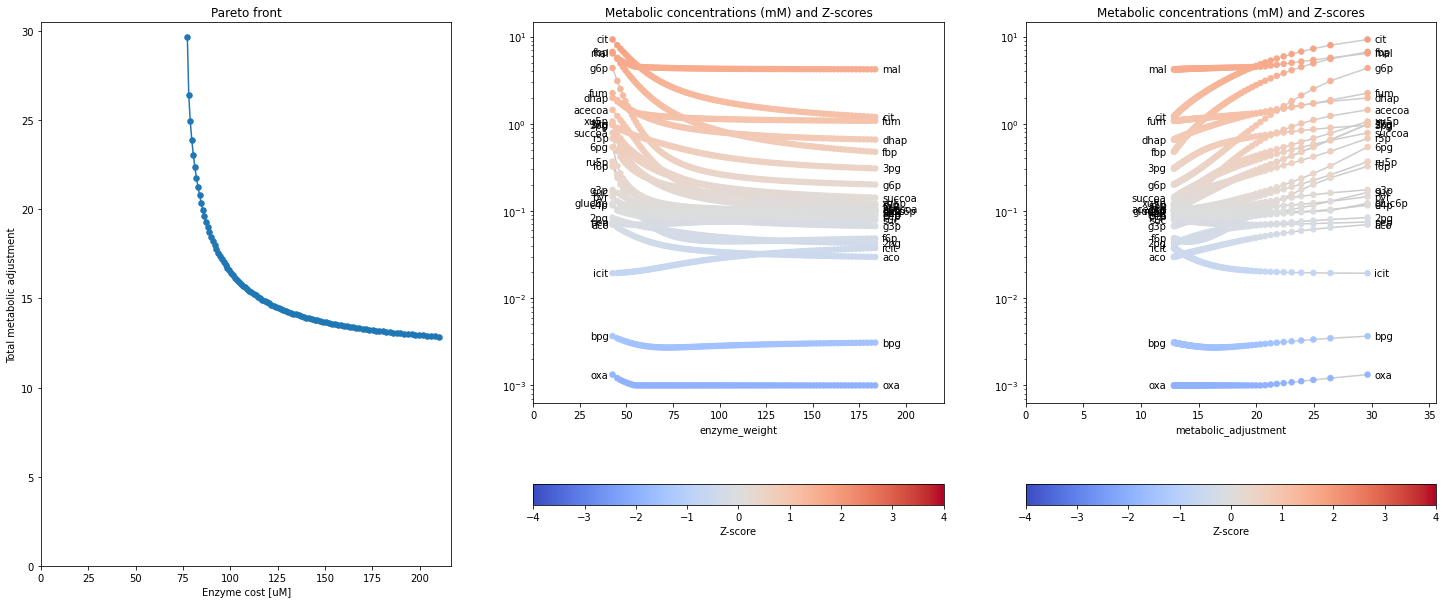

In [7]:
ln_conc_df = df[(df.var_type == "primal") & (df.name == "log_conc")].pivot(
    "weight", "index", "value"
)
conc_df = np.exp(ln_conc_df) * 1e3  # convert to mM
conc_df.columns = model.compound_ids
conc_df = conc_df.loc[:, model.ecf.ln_conc_sigma > model.ecf.MINIMAL_STDEV]

zscores = df[df.var_type == "z_score"].pivot("weight", "index", "value")
zscores.columns = model.compound_ids

fig = plt.figure(figsize=(25, 10))

ax = fig.add_subplot(1, 3, 1)
obj_df.plot(x="enzyme_cost", y="metabolic_adjustment", ax=ax, legend=False)
obj_df.plot.scatter(
    x="enzyme_cost", y="metabolic_adjustment", s=30, ax=ax, legend=False
)

ax.set_xlim(0, None)
ax.set_ylim(0, None)
ax.set_xlabel("Enzyme cost [uM]")
ax.set_ylabel("Total metabolic adjustment")
ax.set_title("Pareto front")

for i, objective in enumerate(["enzyme_weight", "metabolic_adjustment"]):
    ax = fig.add_subplot(1, 3, i + 2)
    xargmin = obj_df[objective].argmin()
    xmin = obj_df[objective].iat[xargmin]
    xargmax = obj_df[objective].argmax()
    xmax = obj_df[objective].iat[xargmax]

    ax.plot(obj_df[objective], conc_df.values, color=(0.8, 0.8, 0.8), zorder=1)
    for met, row in conc_df.iteritems():
        sc = ax.scatter(
            obj_df[objective],
            row.values,
            c=zscores.loc[:, met],
            s=30,
            cmap="coolwarm",
            vmin=-4,
            vmax=4,
            zorder=2,
        )
        ax.text(xmin * 0.95, row.iat[xargmin], met, ha="right", va="center")
        ax.text(xmax * 1.02, row.iat[xargmax], met, ha="left", va="center")

    ax.set_xlim(0, xmax * 1.2)
    ax.set_yscale("log")
    ax.set_xlabel(objective)
    ax.set_title("Metabolic concentrations (mM) and Z-scores")
    plt.colorbar(sc, label="Z-score", orientation="horizontal")

display(fig)
pdf.savefig(fig)
plt.close(fig)

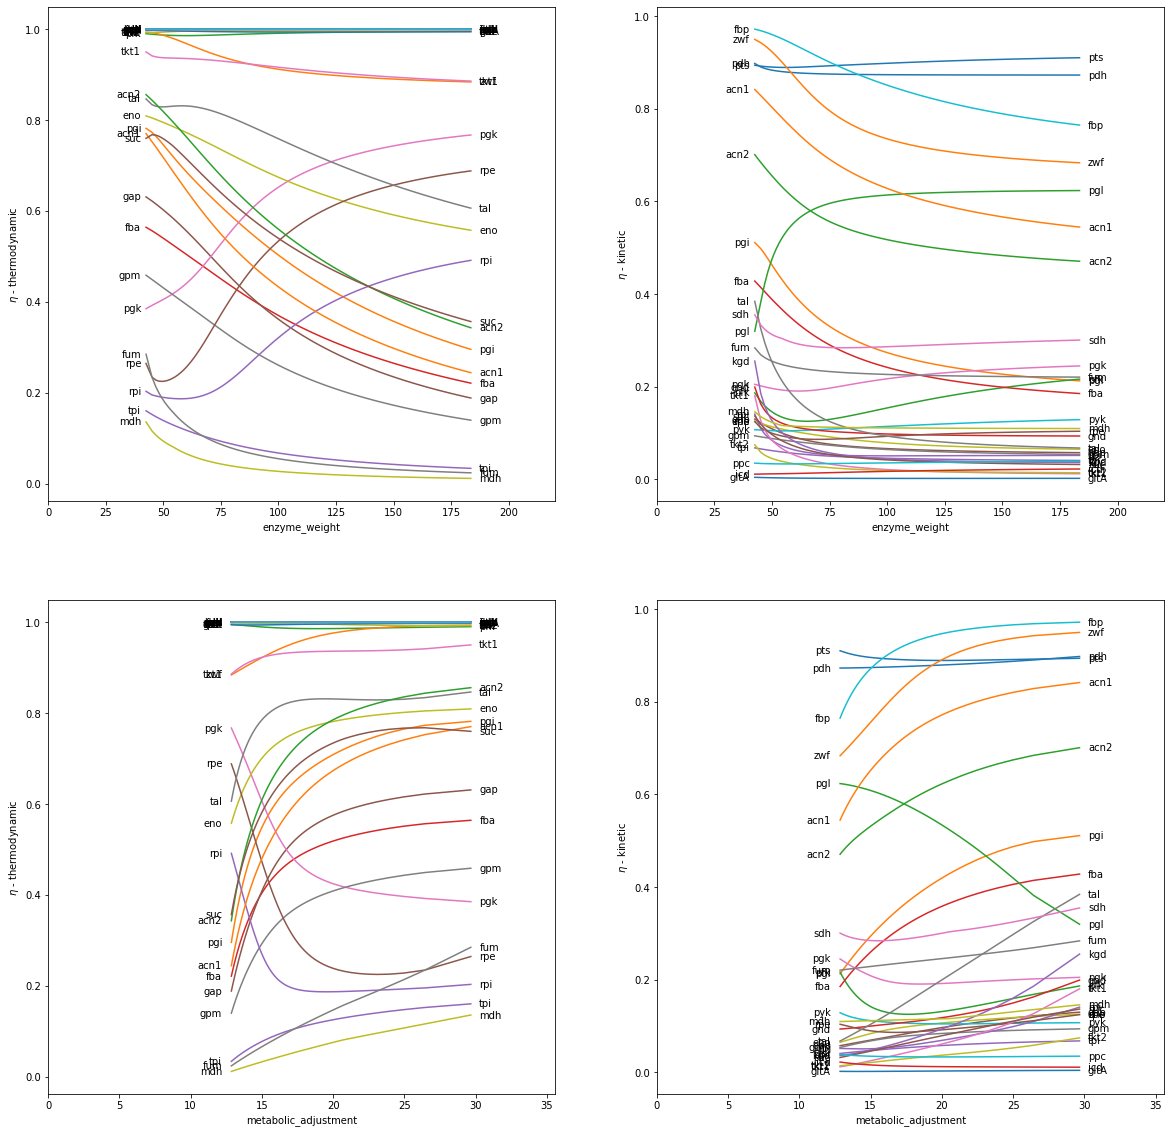

In [8]:
eta_thermo = df[(df.var_type == "eta") & (df.name == "thermodynamic")].pivot(
    "weight", "index", "value"
)
eta_thermo.columns = model.reaction_ids

eta_kinetic = df[(df.var_type == "eta") & (df.name == "kinetic")].pivot(
    "weight", "index", "value"
)
eta_kinetic.columns = model.reaction_ids

fig, axs = plt.subplots(2, 2, figsize=(20, 20))

for i, objective in enumerate(["enzyme_weight", "metabolic_adjustment"]):
    xargmin = obj_df[objective].argmin()
    xmin = obj_df[objective].iat[xargmin]
    xargmax = obj_df[objective].argmax()
    xmax = obj_df[objective].iat[xargmax]

    for j, eta_name in enumerate(["thermodynamic", "kinetic"]):
        eta_df = df[(df.var_type == "eta") & (df.name == eta_name)].pivot(
            "weight", "index", "value"
        )
        eta_df.columns = model.reaction_ids
        ax = axs[i, j]
        ax.plot(obj_df[objective], eta_df.values)
        for rxn, row in eta_df.iteritems():
            ax.text(xmin * 0.95, row.iat[xargmin], rxn, ha="right", va="center")
            ax.text(xmax * 1.02, row.iat[xargmax], rxn, ha="left", va="center")
        ax.set_xlim(0, xmax * 1.2)
        ax.set_xlabel(objective)
        ax.set_ylabel(r"$\eta$ - " + eta_name)

display(fig)
pdf.savefig(fig)
plt.close(fig)

In [9]:
# check the correlation coefficient of each solution compared to the enzyme and metabolite validation data
model.add_validation_data("../ecoli_noor_2016_reference.tsv")

In [10]:
c_meas = (
    model._val_df_dict["Concentration"].set_index("Compound").Value.apply(pd.to_numeric)
    * 1e-3
)  # convert from mM to M
ln_met_meas = np.log(c_meas[c_meas > 0])
ln_met_meas.name = "measured"

ln_met_pred = df[(df.var_type == "primal") & (df.name == "log_conc")].pivot(
    "weight", "index", "value"
)
ln_met_pred.columns = model.compound_ids
ln_met_pred = ln_met_pred.loc[
    :, model.ecf.ln_conc_sigma > model.ecf.MINIMAL_STDEV
]  # drop metabolites with essentially fixed concentrations

data = []
for r, row in ln_met_pred.iterrows():
    x = row.copy()
    x.name = "predicted"
    met_df = pd.DataFrame([x, ln_met_meas]).T.dropna()
    r_squared = met_df.corr().iat[0, 1] ** 2
    resid = met_df.measured.values - met_df.predicted.values
    rmse = np.sqrt(np.power(resid, 2).mean()) / np.log(
        10
    )  # convert the RMSE to log10 units
    data.append((r, rmse, r_squared))
met_rmse_df = pd.DataFrame(data=data, columns=["weight", "RMSE", "$R^2$"])

In [11]:
c_meas = (
    model._val_df_dict["EnzymeConcentration"]
    .set_index("Reaction")
    .Value.apply(pd.to_numeric)
    * 1e-3
)  # convert from mM to M
ln_enz_meas = np.log(c_meas[c_meas > 0])
ln_enz_meas.name = "measured"

ln_enzyme_pred = df[(df.var_type == "primal") & (df.name == "log_enzyme_conc")].pivot(
    "weight", "index", "value"
)
ln_enzyme_pred.columns = model.reaction_ids

data = []
for r, row in ln_enzyme_pred.iterrows():
    x = row.copy()
    x.name = "predicted"
    enz_df = pd.DataFrame([x, ln_enz_meas]).T.dropna()
    r_squared = enz_df.corr().iat[0, 1] ** 2
    resid = enz_df.measured.values - enz_df.predicted.values
    rmse = np.sqrt(np.power(resid, 2).mean()) / np.log(
        10
    )  # convert the RMSE to log10 units
    data.append((r, rmse, r_squared))
enz_rmse_df = pd.DataFrame(data=data, columns=["weight", "RMSE", "$R^2$"])

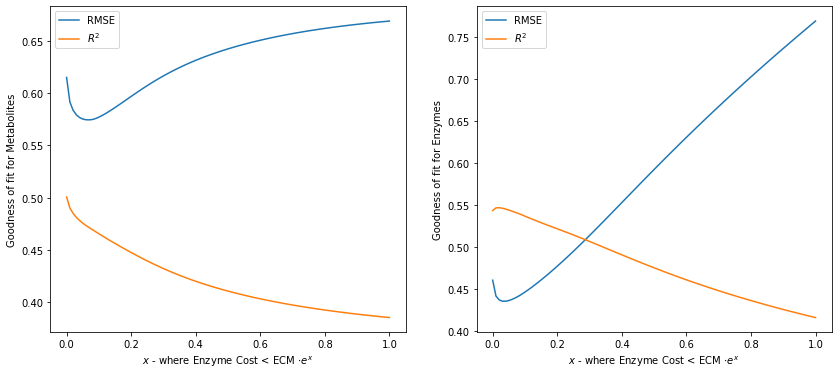

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
ax = axs[0]
met_rmse_df.plot(x="weight", y="RMSE", ax=ax)
met_rmse_df.plot(x="weight", y="$R^2$", ax=ax)
ax.set_ylabel("Goodness of fit for Metabolites")
ax.set_xlabel(r"$x$ - where Enzyme Cost < ECM $\cdot e^{x}$")

ax = axs[1]
enz_rmse_df.plot(x="weight", y="RMSE", ax=ax)
enz_rmse_df.plot(x="weight", y="$R^2$", ax=ax)
ax.set_ylabel("Goodness of fit for Enzymes")
ax.set_xlabel(r"$x$ - where Enzyme Cost < ECM $\cdot e^{x}$")

display(fig)
pdf.savefig(fig)
plt.close(fig)

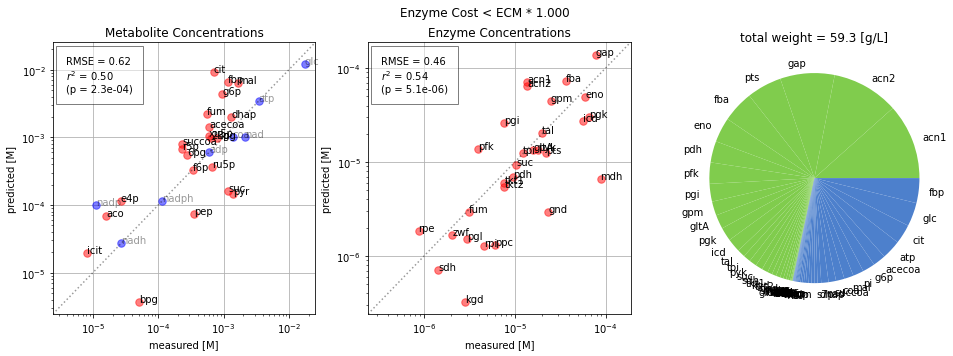

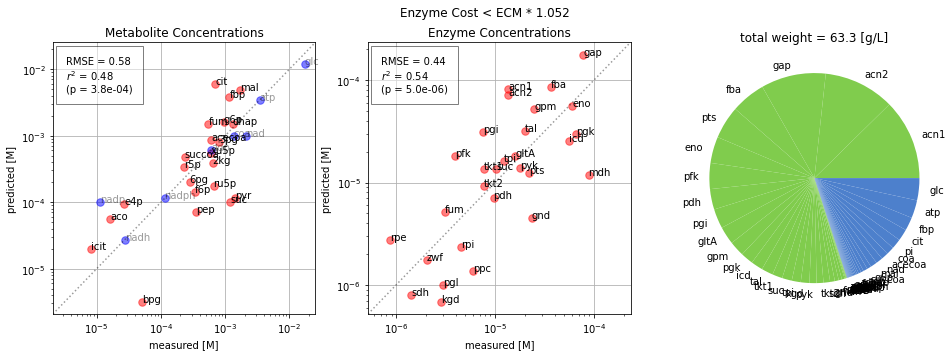

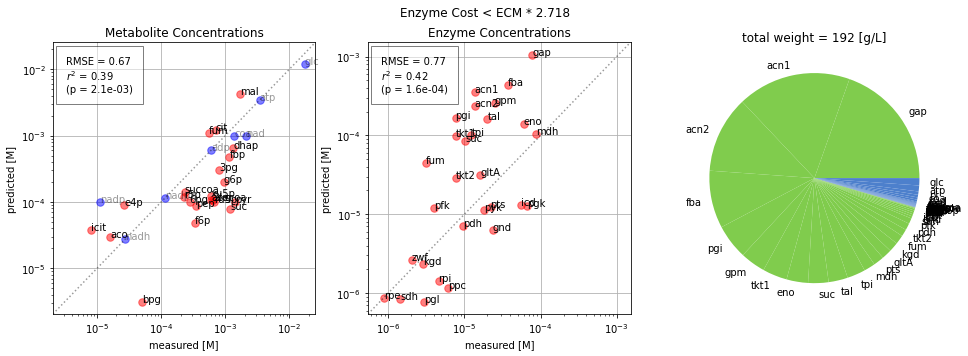

In [13]:
def plot_results(ln_conc):
    ecm_sol = PathwayEcmSolution(model, 0, ln_conc)
    fig = plt.figure(figsize=(16, 5))
    ax = fig.add_subplot(1, 3, 1, xscale="log", yscale="log")
    ax.set_title("Metabolite Concentrations")
    ecm_sol.validate_metabolite_conc(ax)

    ax = fig.add_subplot(1, 3, 2, xscale="log", yscale="log")
    ax.set_title("Enzyme Concentrations")
    ecm_sol.validate_enzyme_conc(ax)

    ax = fig.add_subplot(1, 3, 3)
    ecm_sol.plot_volumes_pie(ax=ax)
    return fig


for pos in [0, 0.05, 0.999]:
    idx = int(ln_conc_df.shape[0] * pos)
    fig = plot_results(ln_conc_df.iloc[idx, :].values)
    x = ln_conc_df.index[idx]
    fig.suptitle(f"Enzyme Cost < ECM * {np.exp(x):.3f}")
    display(fig)
    pdf.savefig(fig)
    plt.close(fig)

In [14]:
pdf.close()